# Attention 구현

### 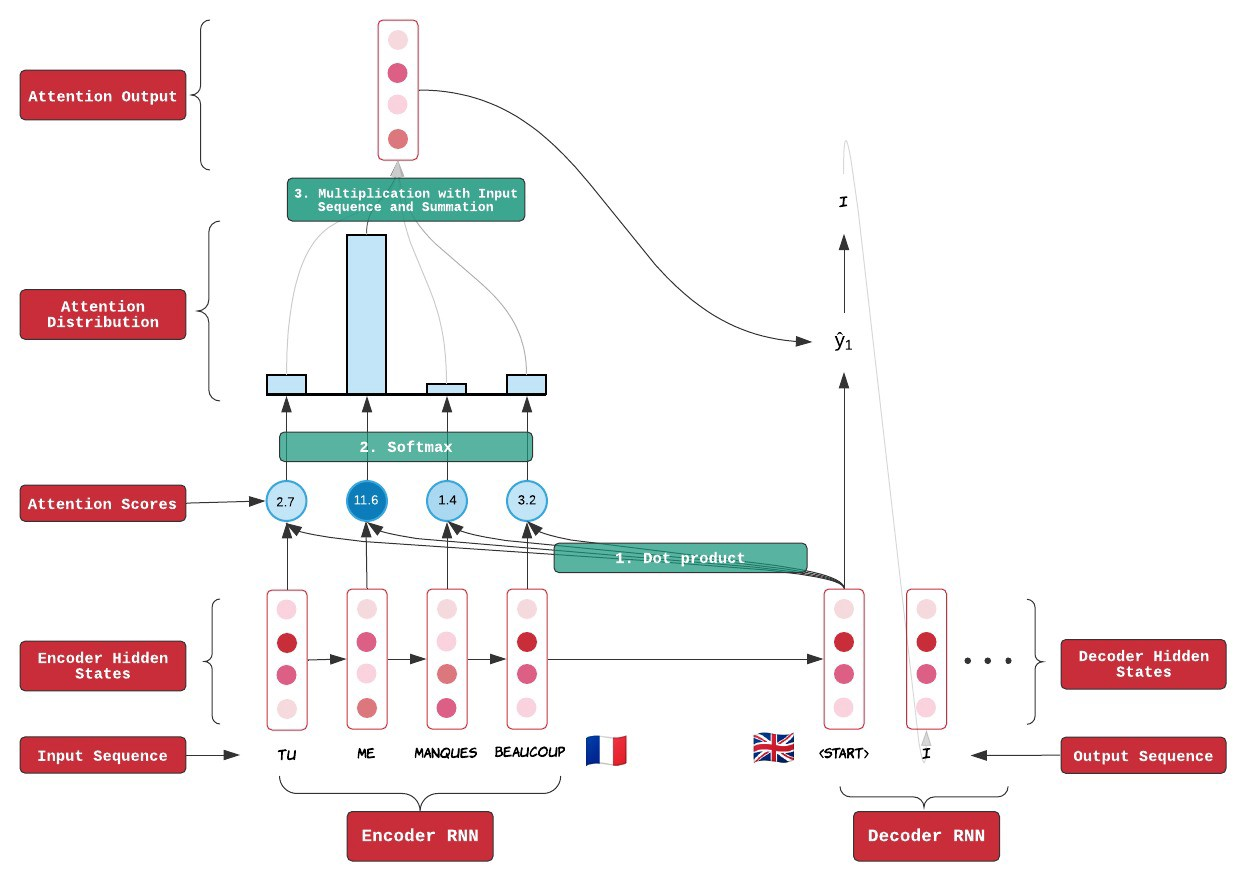

In [2]:
import random
import tensorflow as tf
from konlpy.tag import Okt

## 1) Hyperparameter

In [32]:
EPOCHS = 50
NUM_WORDS=2000

## 2) Modeling

>### 1. Encoder
- embedding : maximum word length : 2000 & 64 embedding nodes
- lstm : 512 nodes ( return_state = True : to get the Hidden & Cell state )
- no need of (predicted y) in LSTM ! will give (real y) as a input of next state

In [40]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder,self).__init__()
        self.emb = tf.keras.layers.Embedding(NUM_WORDS,64) # maximum of 2000 words
        #self.lstm = tf.keras.layers.LSTM(512,return_state=True)
        self.lstm = tf.keras.layers.LSTM(512,return_sequences=True, return_state=True)
    
    def call(self,x,training=False,mask=None):
        x = self.emb(x)
        #_,h,c = self.lstm(x) 
        H,h,c = self.lstm(x) # H : 모든 hidden state에 대한 output 필요! 
        return H,h,c

>###  2. Decoder
- embedding & LSTM & Dense
- Dense : give probability of 2000 words
- give output of lstm as a input of the next state

In [41]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder,self).__init__()
        self.emb = tf.keras.layers.Embedding(NUM_WORDS,64)
        self.lstm = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)
        self.att = tf.keras.layers.Attention()
        self.dense = tf.keras.layers.Dense(NUM_WORDS,activation='softmax') 
    
    def call(self,inputs,training=False, mask=None):
        x,s0,c0,H = inputs 
        # x : shifted output
        # s0 : (initial : context) & output of decoder hidden state
        # c0 : (initial : context) & output of decoder cell state
        # H : EVERY hidden state output
        x = self.emb(x)
        S,h,c = self.lstm(x, initial_state=[s0,c0])
        
        S_ = tf.concat([s0[:,tf.newaxis,:],S[:,:-1,:]],axis=1) # Query (initial : context + after : output of decoder hidden state)
        A = self.att([S_,H]) 
        y = tf.concat([S,A], axis=-1)
        
        return self.dense(y), h,c

>### 3. Attention_s2s

In [42]:
class Attention_s2s(tf.keras.Model):
    def __init__(self,sos,eos):
        super(Seq2seq,self).__init__()
        self.enc= Encoder()
        self.dec = Decoder()
        self.sos = sos
        self.eos = eos
    
    def call(self, inputs, training=False, mask=None):
        # (1) Training
        if training is True:
            x,y = inputs
            H,h,c = self.enc(x) # encode ( input : X / output : H(Hidden) & C(Cell) )
            y,_,_ = self.dec((y,h,c,H)) # decode ( input : previous actual Y, H, C / output : predicted Y )
            return y # final : return the predicted words!
        
        # (2) Testing
        else :
            x = inputs # no label data
            H,h,c = self.enc(x) # encode 
            y = tf.conver_to_tensor(self.sos) # initial y : sos
            y = tf.reshape(y,(1,1))            
            seq = tf.TensorArray(tf.int32, 64)
            
            for idx in tf.range(64):
                y,h,c = self.dec([y,h,c,H]) # input : y(previous prediction),embedded h&c
                                                    # output : y(Softmax result)
                y = tf.cast(tf.argmax(y, axis=-1), dtype=tf.int32)  # get the biggest prob
                y = tf.reshape(y,(1,1))
                seq = seq.write(idx,y)  # ex. (idx:5, result : Boy)
                if y==self.eos:
                    break
            return tf.reshape(seq.stack(), (1,64))

## 3) Train & Test function

In [43]:
@tf.function
def train_step(model, inputs, labels, loss_object, optimizer, train_loss,train_accuracy):
    output_labels = labels[:,1:] # real answer (2,3,4..100)
    shifted_labels = labels[:,:-1] # give label as an input to next state (1,2,3...,99)
    
    with tf.GradientTape() as tape:
        # input variable : inputs(H,C) + shifted_labels(previous label)
        predictions = model([inputs, shifted_labels], training=True) 
        loss = loss_object(output_labels, predictions) # (real answer) VS (predicted answer)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(output_labels, predictions)
    
@tf.function
def test_step(model,inputs):
    return model(inputs, training=False)

## 4) Final Dataset

In [44]:
dataset_file = 'chatbot_data.csv'
okt = Okt()

## 1. preparing Q&A dataset
with open(dataset_file,'r',encoding="utf-8") as file:
    lines = file.readlines()
    seq = [' '.join(okt.morphs(line)) for line in lines] # 형태소 분석

questions = seq[::2] # even numbers 
answers = ['\t' + lines for lines in seq[1::2]]

num_samples = len(questions)
perm = list(range(num_samples)) # 
random.seed(0)
random.shuffle(perm)

train_q = list()
train_a = list()
test_q = list()
test_a = list()

for idx, qna in enumerate(zip(questions, answers)):
    q,a= qna
    # train_test split : (8 : 2)
    if perm[idx] > num_samples//5:
        train_q.append(q)
        train_a.append(a)
    else:
        test_q.append(q)
        test_a.append(a)

# 2. Tokenize ( word -> number )& filtering
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=NUM_WORDS,
                                                 filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')
tokenizer.fit_on_texts(train_q+train_a) # fit tokenizer
train_q_seq = tokenizer.texts_to_sequences(train_q)
train_a_seq = tokenizer.texts_to_sequences(train_a)
test_q_seq = tokenizer.texts_to_sequences(test_q)
test_a_seq = tokenizer.texts_to_sequences(test_a)

# 3. Padding ( train : pre_pad, test : post_pad)
x_train = tf.keras.preprocessing.sequence.pad_sequences(train_q_seq,
                                                       value=0,padding='pre',maxlen=64)
y_train = tf.keras.preprocessing.sequence.pad_sequences(train_a_seq,
                                                       value=0,padding='post',maxlen=65)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_q_seq,
                                                       value=0,padding='pre',maxlen=64)
y_test = tf.keras.preprocessing.sequence.pad_sequences(test_a_seq,
                                                       value=0,padding='post',maxlen=65)

# 4. Final Dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(32).prefetch(1024)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(1).prefetch(1024)

## 5) Model, Losses, Optimizer

In [45]:
model = Seq2seq(sos=tokenizer.word_index['\t'],
               eos=tokenizer.word_index['\n'])
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

## 6) Train

In [46]:
for epoch in range(EPOCHS):
    # train in one epoch
    for seqs, labels in train_ds:
        train_step(model,seqs,labels,loss_object,optimizer, train_loss, train_accuracy)
        
    # result
    template = 'Epoch {}, Loss : {}, Accuracy : {}'
    if epoch%10==0:
        print(template.format(epoch,
                              train_loss.result(),
                              train_accuracy.result()*100))
    
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch 0, Loss : 2.722676992416382, Accuracy : 84.54730224609375
Epoch 10, Loss : 0.4059935212135315, Accuracy : 92.79056549072266
Epoch 20, Loss : 0.32857412099838257, Accuracy : 93.7108383178711
Epoch 30, Loss : 0.27873319387435913, Accuracy : 94.25516510009766
Epoch 40, Loss : 0.23898127675056458, Accuracy : 94.72118377685547


## 7) Test

In [ ]:
for test_seq, test_labels in test_ds:
    pred = test_step(model, test_seq) # model & x input
    question_text = tokenizer.sequences_to_texts(test_seq.numpy())
    real_text = tokenizer.sequences_to_texts(test_labels.numpy())
    pred_text = tokenizer.sequences_to_texts(pred.numpy())
    print('_________________________________')
    print('question: ', question_text)
    print('real answer: ', real_text)
    print('predicted answer: ', pred_text)